# Guided Project: Credit Card Customer Segmentation

This project is about to help a credit card company to segment his clients into different groups in order to apply different business strategies for each type of customer.

We'll be using the K-means algorithm to segment the data.

## Process

The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different. So we'll follow the below steps to achieve the company's goal.

- Analyze the dataset;
- Prepare the data for modeling;
- Find an appropriate number of clusters;
- Segment the data;
- Interpret and explain the results.

## Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Dataset

### Columns' Dictionary

- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income`: the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

### Review

In [2]:
dataset = pd.read_csv('customer_segmentation.csv')
dataset.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

From above we can have the following idea on the dataset
- 14 columns and 10127 rows
- There is one column to identify the customer - `customer_id`, which is not required for analysis
- We have 3 columns are as `object` type, rest are numeric with `int64` and `float64`.

### Correlations

<AxesSubplot:>

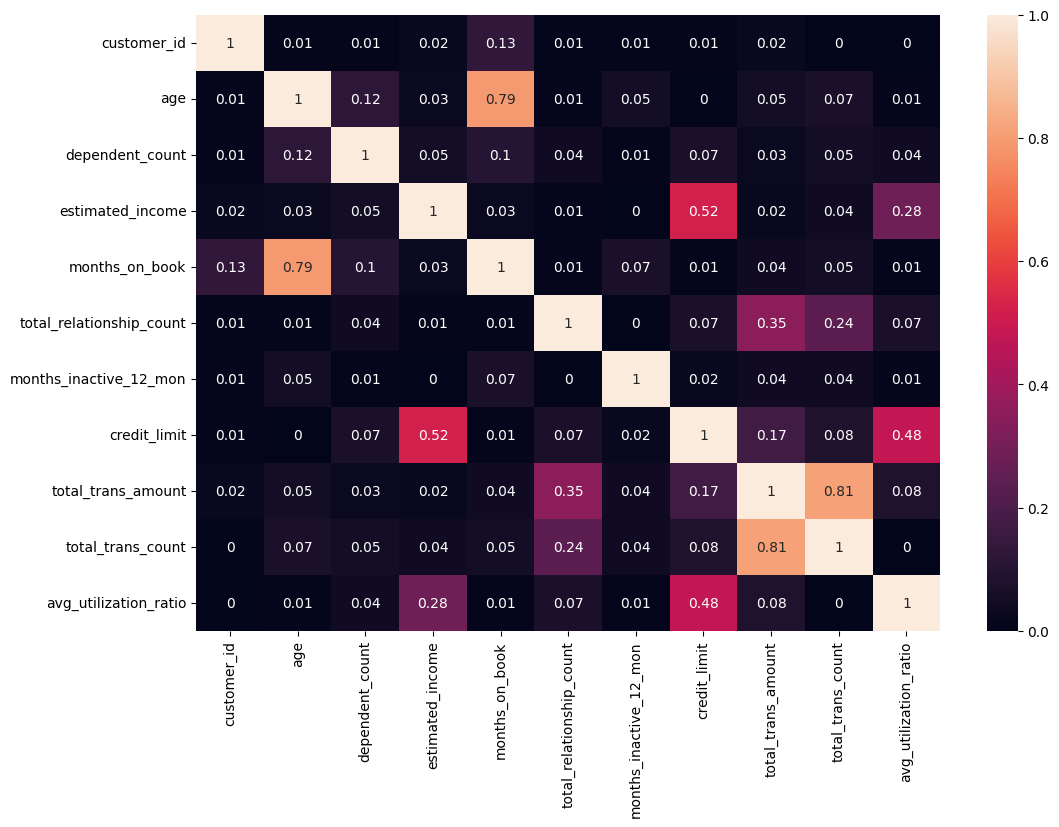

In [4]:
corr_dataset = abs(dataset.corr().round(2))

plt.figure(figsize=(12, 8))
sns.heatmap(corr_dataset, annot=True)

Lets extract the combinations that have high correlation value.

In [5]:
# extract correlation > 0.75
mask = (corr_dataset > 0.75) & (corr_dataset != 1)

# Stack the masked DataFrame and reset the index
filtered = mask.stack().reset_index()

# Filter only rows where the condition is True
filtered_combinations = filtered[filtered[0]]

# Rename columns for clarity
filtered_combinations.columns = ['row', 'col', 'mask_value']

filtered_combinations = filtered_combinations.copy()  # Ensure you're working on a copy
filtered_combinations.loc[:, 'value'] = filtered_combinations.apply(
    lambda x: corr_dataset.loc[x['row'], x['col']], axis=1
)

# Remove duplicate pairs by ensuring the smaller name comes first
filtered_combinations = filtered_combinations[filtered_combinations['row'] < filtered_combinations['col']]

# Drop the "mask_value" column if no longer needed
filtered_combinations = filtered_combinations.drop(columns=['mask_value'])

print(filtered_combinations)

                   row                col  value
15                 age     months_on_book   0.79
97  total_trans_amount  total_trans_count   0.81


Both the `age v.s. months_on_book` and `total_trans_amount v.s. total_trans_count` have about 0.8 correlation.

### Numeric Columns - Distributions 

Now lets plot each the numeric column to check their distribution. 

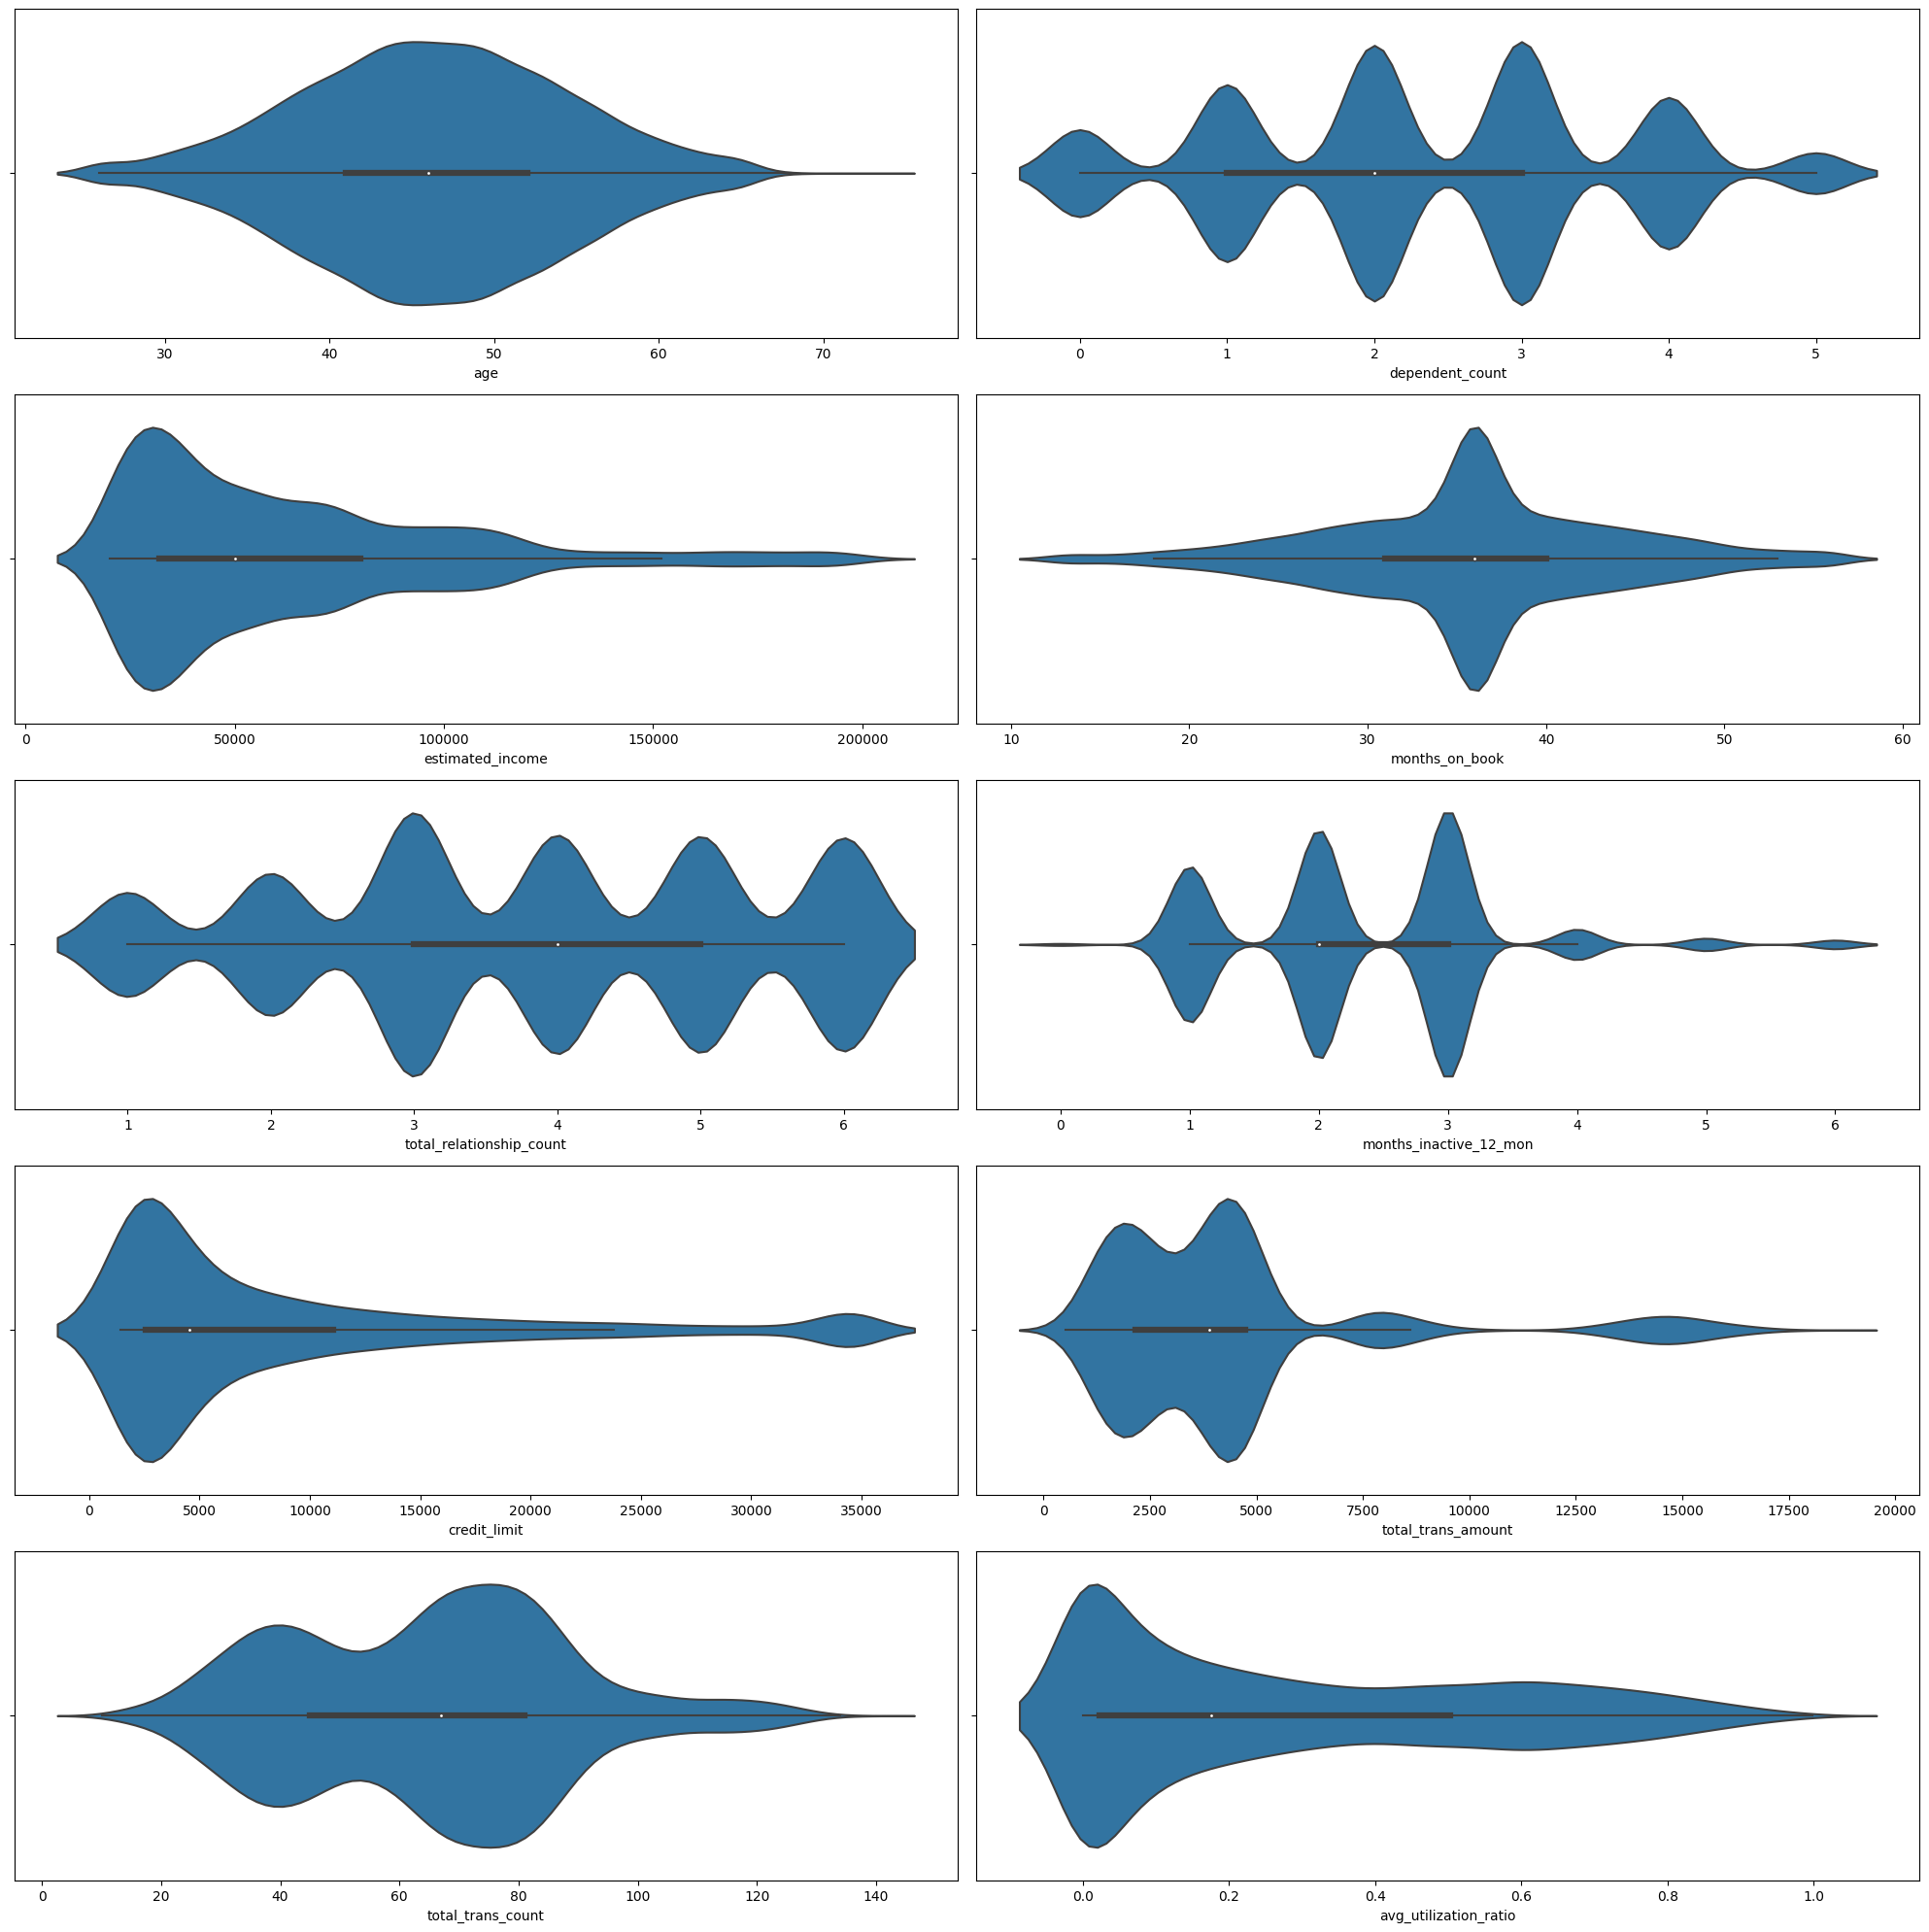

In [6]:
# Extract numeric columns
numeric_columns = dataset.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('customer_id')

plt.figure(figsize=(20, 20))
for i, f in enumerate(numeric_columns, start=1):
    plt.subplot(5, 2, i)
    sns.violinplot(data=dataset, x=f)
    
plt.tight_layout()

From above we can see that:
- The `age` is a normal distribution, where the peak is around `45`.
- The `dependent_count` graphed like a normal distribution, but it's a discrete variable with 2 peaks, so it's considered as symmetric distribution.
- The `estimated_income` is a right-skewed distribution, with most values concentrated on the lower end.
- The `months_on_book` appears to be more peaked and symmetric, with data clustering tightly around a central range.
- The `total_relationship_count` is kinda a uniform distribution, but with a slightly higher concentration at 3 and lower counts at 1 and 2.
- The `months_inactive_12_mon` is a asymmetrical distribution, with values 1, 2, and 3 being the most frequent, while higher values are rare.
- The `credit_limit` is a highly right-skewed distribution, peaking around 2.5k, with a long tail toward higher values.
- The `total_trans_amt` is also a highly right-skewed distribution, with a concentration at lower values and only a few high values.
- The `total_trans_count` is a asymmetrical distribution, with peaks around 80 and 40, and very few counts above 100.
- The `avg_utilization_ratio` has a right-skewed distribution, with most values concentrated below 0.2.

### Categorical Columns

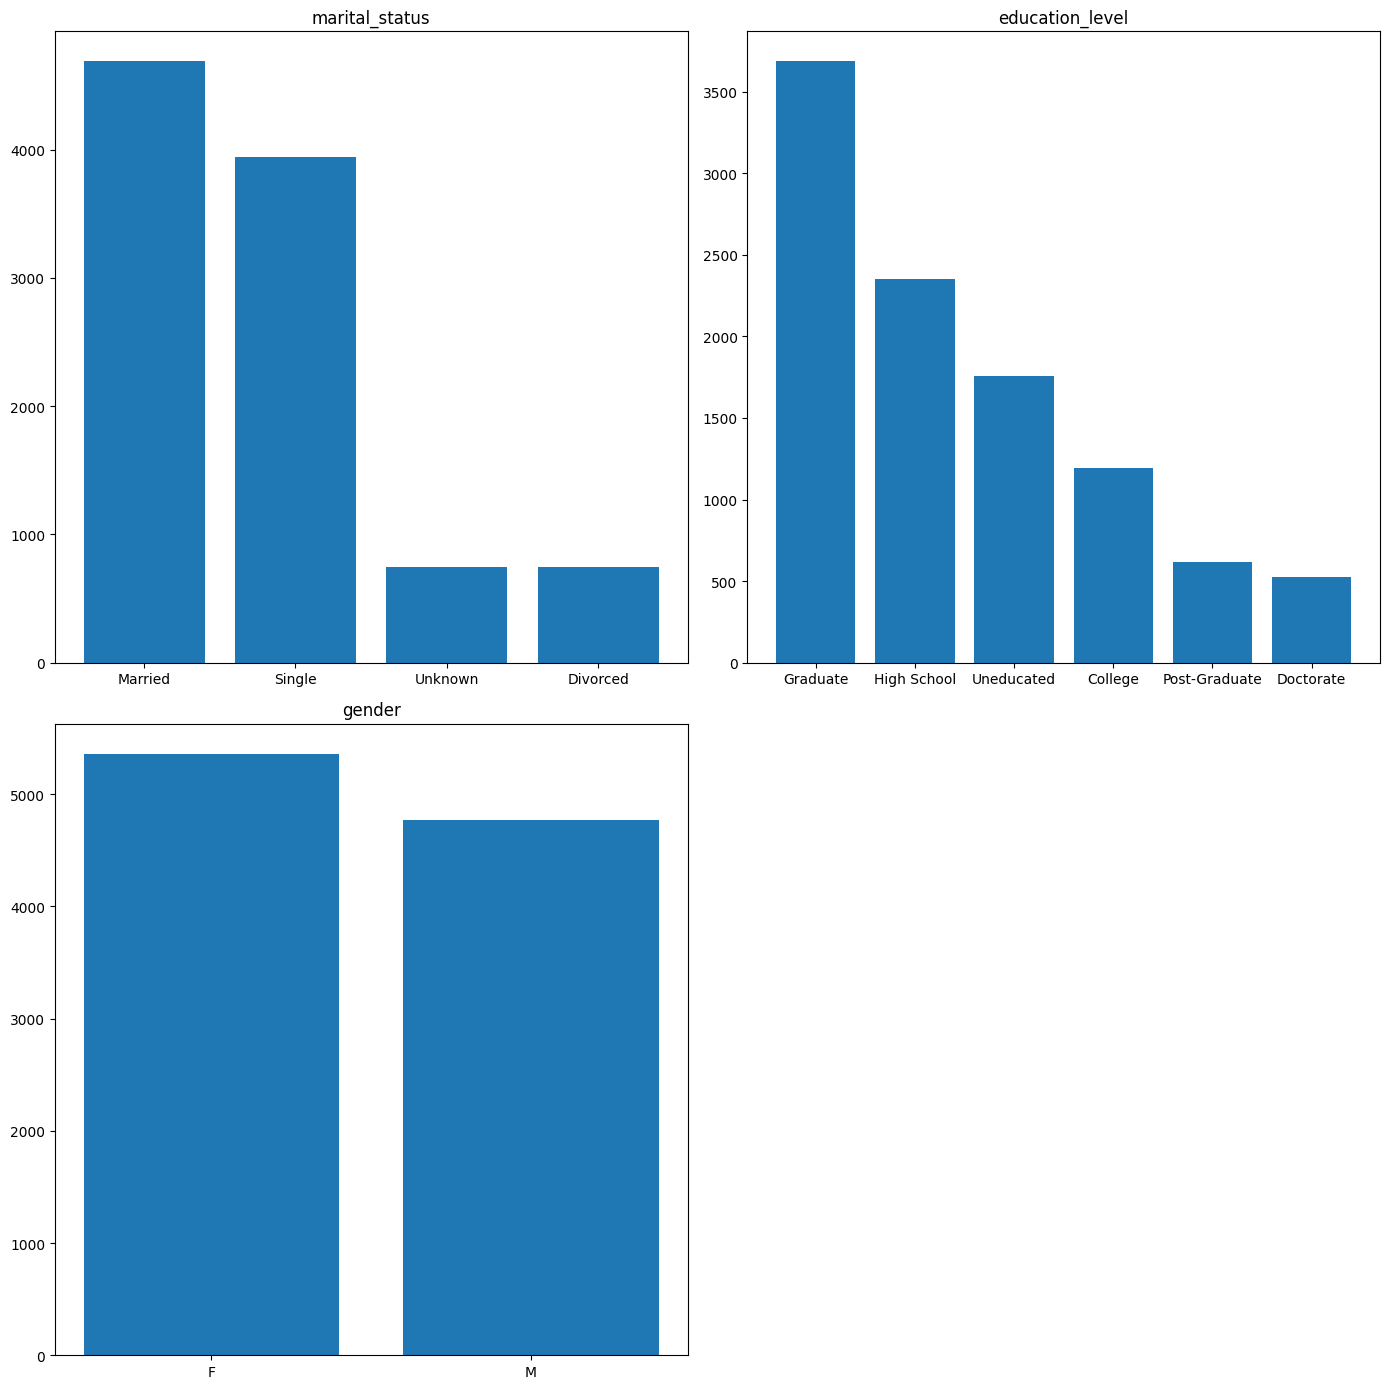

In [7]:
remaining_columns = list(set(dataset.columns.tolist()) - set(numeric_columns))
remaining_columns.remove('customer_id')

plt.figure(figsize=(14, 14))
for i, f in enumerate(remaining_columns, start=1):
    plt.subplot(2, 2, i)
    
    # Get unique values (x-axis) and their counts (y-axis)
    value_counts = dataset[f].value_counts()
    x = value_counts.index
    y = value_counts.values
    
    # Plot the bar chart
    plt.bar(x, y)
    plt.title(f)
    
plt.tight_layout()
plt.show()

From above:
- There are a few customers with `doctorate` level, most of them are with `graduate` or `high school` level.
- Most of the customers are either `single` or `married`.
- The customers' gender are roughly equal.

## Feature Engineering

In order to do the analysis later, we need to convert the categorical columns to numeric. As above shown, we have three:
- `gender` has only 2 unique values, "M" and "F", which is possible to replace them with 1 and 0.
- `education_level` contains 6 unique values, representing levels of education, and it's possible to rank the levels from the lowest to the highest, so we can replace each unique level with a number, assuming we respect the order.
- `marital_status` has 4 unique values, but we're not able to rank them, so we'll use one-hot-encoding to create dummy variables.

In [8]:
dataset_modif = dataset.copy()

# modifying gender
dataset_modif['gender'] = dataset_modif['gender'].map(lambda x: 1 if x=='M' else 0)

# modifying education level
mapping_table = {'Uneducated': 0, 'High School': 1, 'College': 2,
                 'Graduate': 3, 'Post-Graduate': 4, 'Doctorate': 5}
dataset_modif['education_level']=dataset_modif['education_level'].map(mapping_table)

# modifying marital status
dataset_modif = pd.get_dummies(data=dataset_modif, columns=['marital_status'], drop_first=True)

dataset_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## Scaling

Noticed that we have different scaled data across the DataFrame, i.e. the `estimated_income` contains numbers in the range of dozens and hundreds of thousands, while the `dependent_count column` contains numbers from 1 to 5. This will highly impact the analysis, and we need to transform the data to on the same scale.

In [9]:
# drop the unnecessary column
dataset_new = dataset_modif.drop('customer_id', axis=1)

# instantiate the scaler object
scaler = StandardScaler()
scaler.fit(dataset_new)

# scale the data
dataset_new = scaler.transform(dataset_new)

# convert back to df format, as the scaler outcome is an array
dataset_new = pd.DataFrame(dataset_new)

print(dataset_new)

             0         1         2         3         4         5         6   \
0     -0.165406  1.059956  0.503368 -0.752211  0.175810  0.384621  0.763943   
1      0.333570 -0.943436  2.043199  0.662787 -0.967166  1.010715  1.407306   
2      0.583058  1.059956  0.503368  0.662787  0.785397  0.008965  0.120579   
3     -0.789126 -0.943436  1.273283 -0.752211 -0.636973 -0.241473 -0.522785   
4     -0.789126  1.059956  0.503368 -1.459710  0.074212 -1.869317  0.763943   
...         ...       ...       ...       ...       ...       ...       ...   
10122  0.458314  1.059956 -0.266547  0.662787 -0.281380  0.509840 -0.522785   
10123 -0.664382  1.059956 -0.266547  0.662787 -0.560775 -1.368442  0.120579   
10124 -0.290150 -0.943436 -1.036462 -0.752211 -0.738571  0.008965  0.763943   
10125 -2.036565  1.059956 -0.266547  0.662787 -0.382978  0.008965  0.120579   
10126 -0.414894 -0.943436 -0.266547  0.662787 -0.662372 -1.368442  1.407306   

             7         8         9         10      

## Choosing the K

The dataset is ready now! Lets decide the best number of clusters to use by plotting the Elbow Curve.

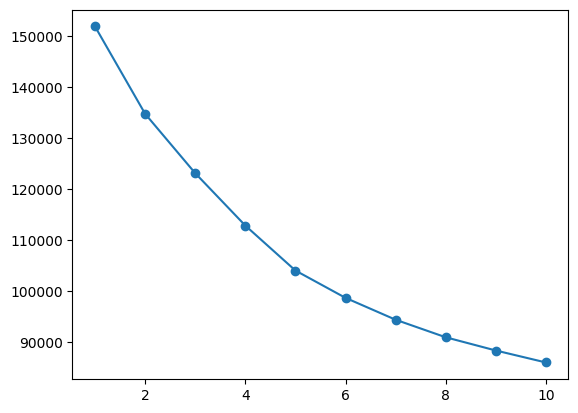

In [10]:
all_inertia  = []

for k in range(1, 11):
    model = KMeans(n_clusters = k, random_state = 99)
    cluster = model.fit_predict(dataset_new)
    all_inertia.append(model.inertia_)
    
plt.plot(range(1, 11), all_inertia, marker='o')
plt.show()

There is no sharp and clear elbow from the above, lets plot the percent decrease in inertia.

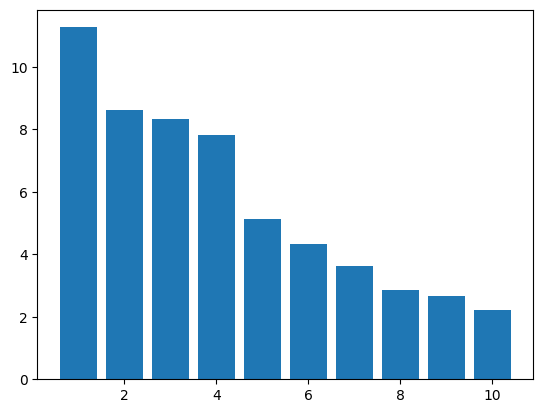

In [11]:
# calculate the percentage decrease of each adjacent inertia
percentages=[]
for k in range(1, 11):
    model1 = KMeans(n_clusters = k, random_state=99)
    model2 = KMeans(n_clusters = k+1, random_state=99)

    clusters1 = model1.fit_predict(dataset_new)
    clusters2 = model2.fit_predict(dataset_new)
    
    inertia1 = model1.inertia_
    inertia2 = model2.inertia_
    
    percentage = 100*(inertia1-inertia2)/inertia1
    percentages.append(percentage)
    
plt.bar(range(1,11), percentages)
plt.show()

The decrease is dramatically low from the fourth to fifth point, compared to the previous, third to fourth. Thus, we'll be choosing K=4.

## Analyzing

In [12]:
# instantiate a new Kmeans object with selected K = 4
model = KMeans(n_clusters = 4, random_state = 99)
cluster = model.fit_predict(dataset_new)

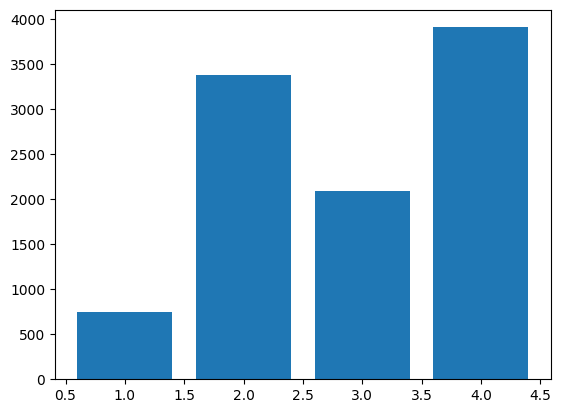

In [13]:
# assign the clusters back to the DataFrame and review the result
dataset['cluster'] = cluster + 1

x = dataset['cluster'].value_counts().index
y = dataset['cluster'].value_counts().values

plt.bar(x, y)
plt.show()

Clusters 4 and 2 are the most populated with cluster 3 being the least.

### Numeric Variables by `CLUSTER`

                          Cluster_1  Cluster_2  Cluster_3  Cluster_4
age                           45.56      45.66      46.39      47.01
dependent_count                2.54       2.23       2.52       2.32
estimated_income           61937.17   46778.99  108958.37   50268.87
months_on_book                35.18      35.34      36.05      36.51
total_relationship_count       3.76       3.84       3.44       4.00
months_inactive_12_mon         2.32       2.36       2.30       2.34
credit_limit                9413.05    5136.15   21123.67    4826.34
total_trans_amount          4706.94    4317.29    6223.61    3448.35
total_trans_count             67.11      67.55      73.22      57.63
avg_utilization_ratio          0.26       0.32       0.08       0.34


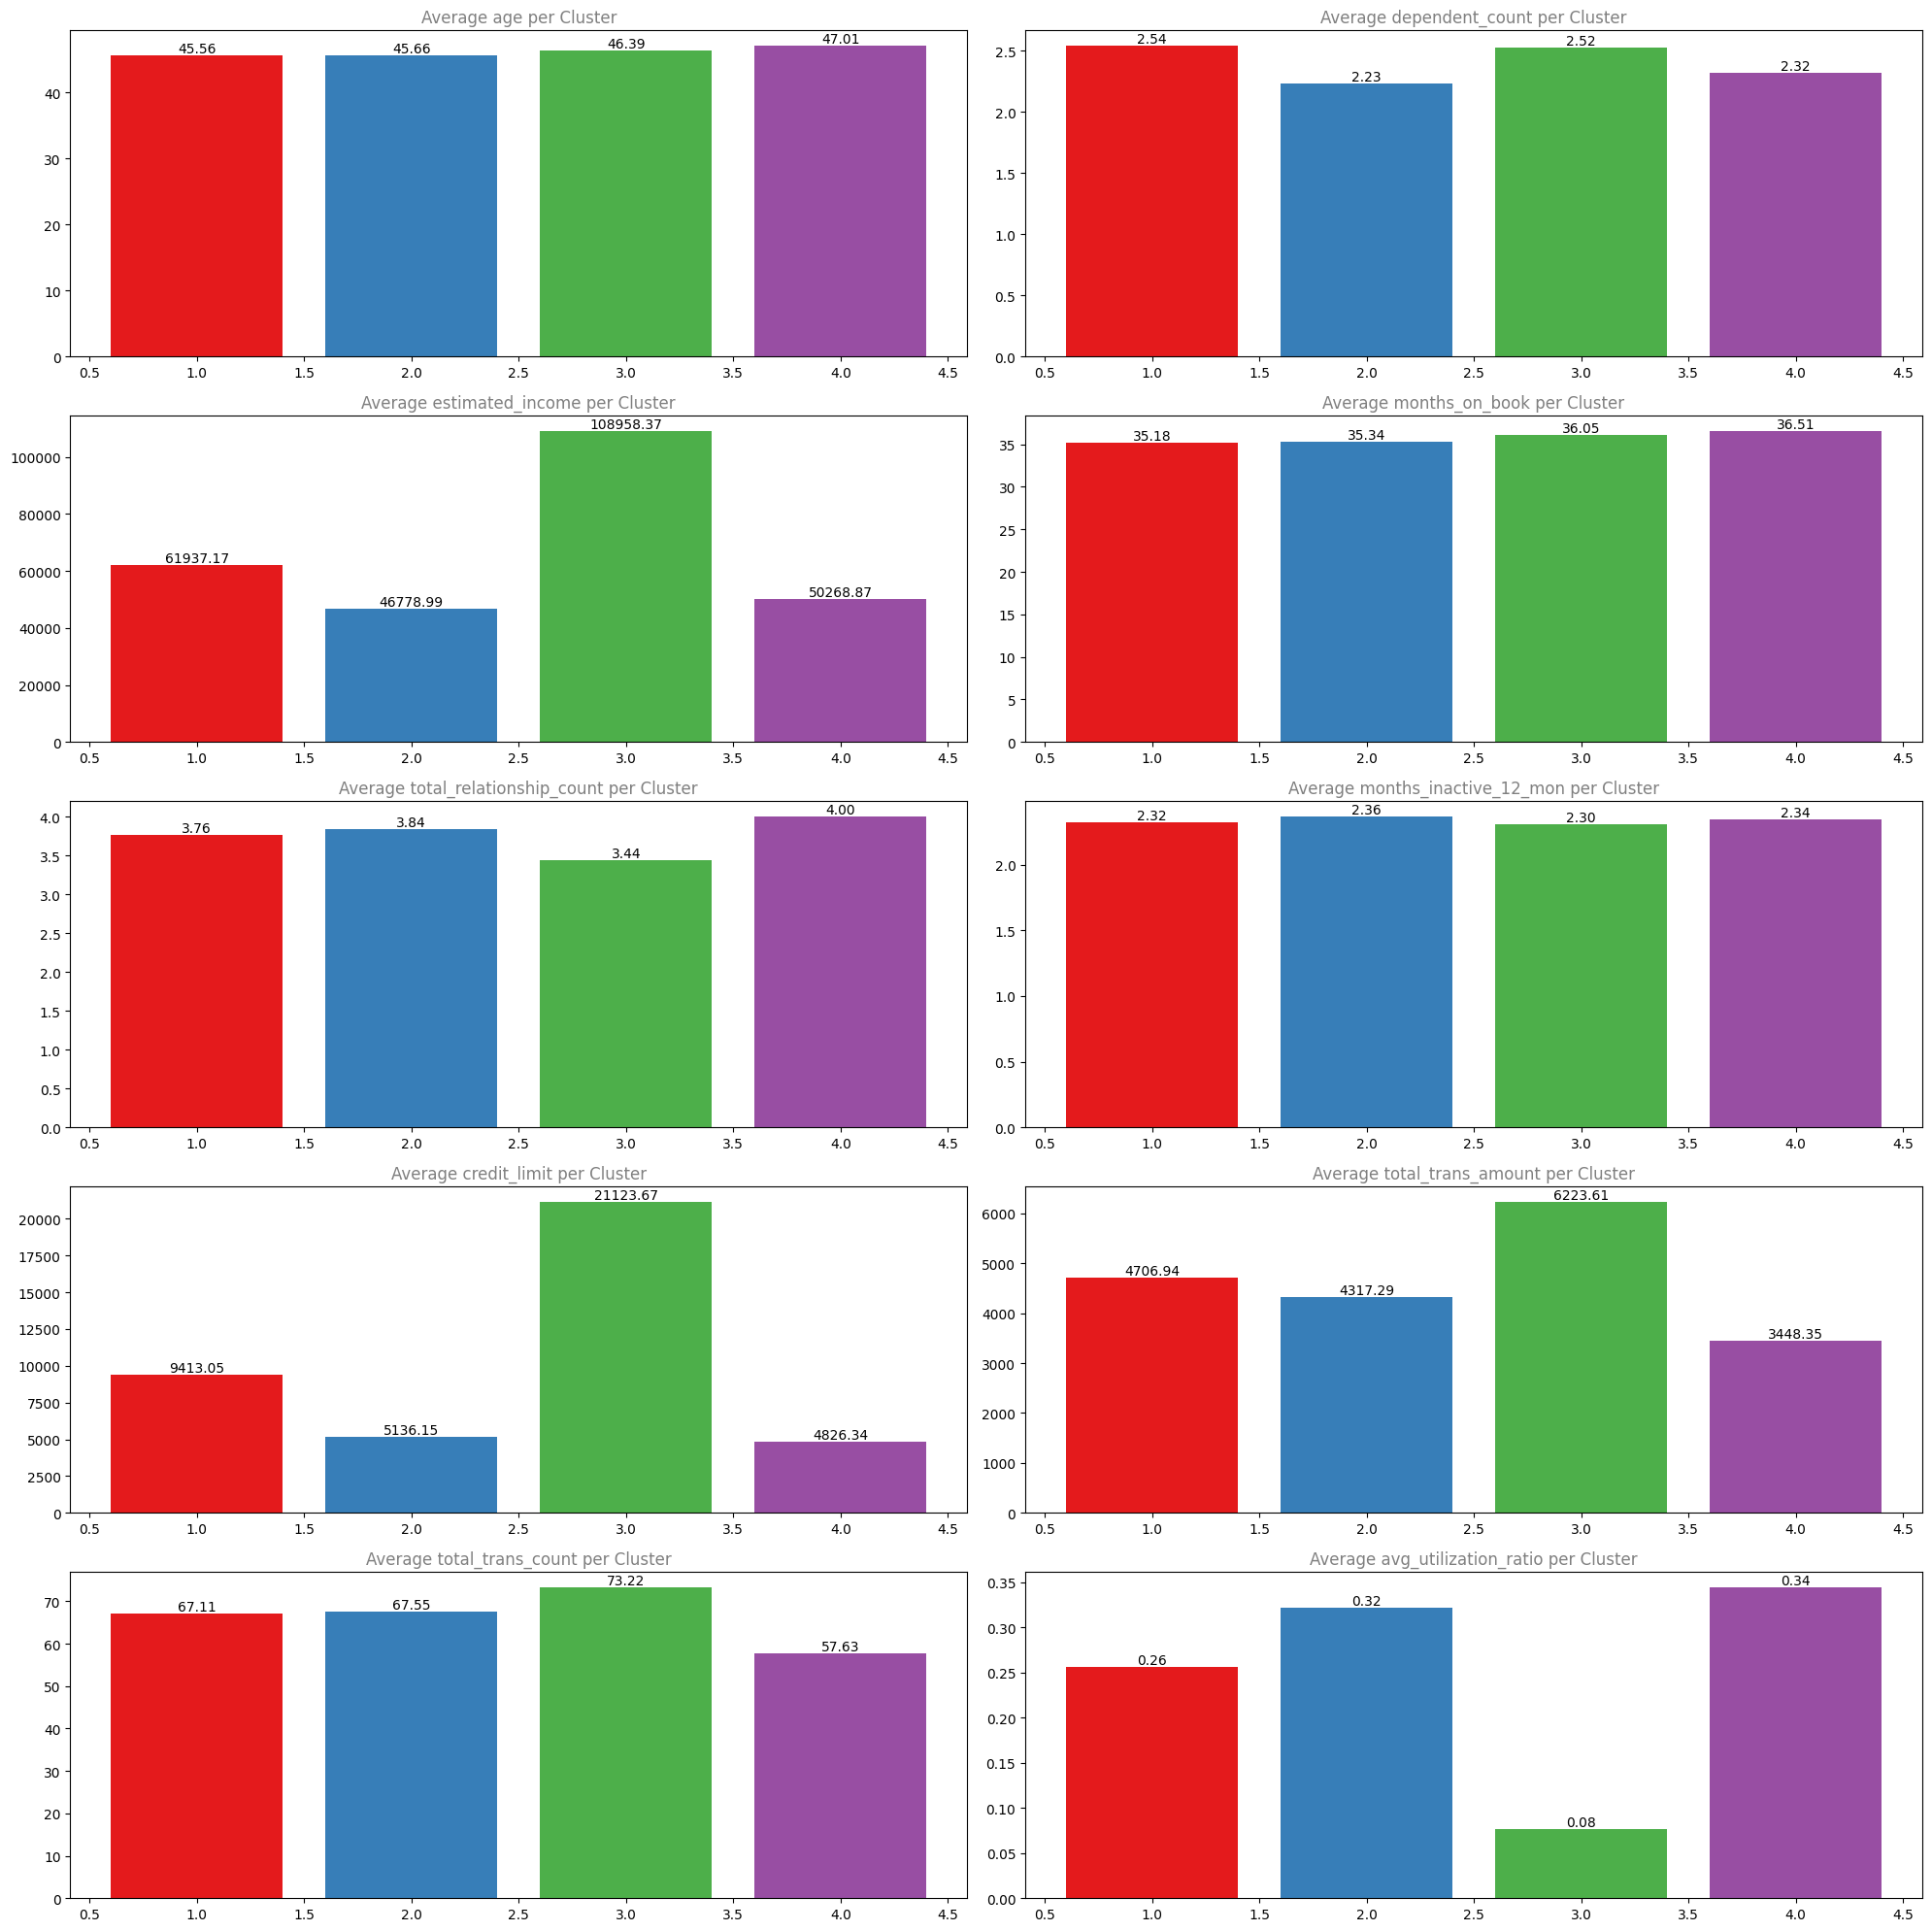

In [14]:
# Extract numeric columns
numeric_columns = dataset.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('customer_id')
numeric_columns.remove('cluster')

# to save the result later to a df
list_of_list = []

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    plt.subplot(5,2,i+1)
    x = dataset.groupby('cluster')[column].mean().index
    y = dataset.groupby('cluster')[column].mean().values
    bars = plt.bar(x, y, color=sns.color_palette('Set1'))
    
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate
            bar.get_height(),                   # y-coordinate
            f'{bar.get_height():.2f}',          # Text to display (formatted to 2 decimal places)
            ha='center',                        # Horizontal alignment
            va='bottom'                         # Vertical alignment
            )
    
    plt.title(f'Average {column} per Cluster', alpha=0.5)
    
    list_of_list.append(y)

# save to a DataFrame
mean_by_cluster = pd.DataFrame(list_of_list)
mean_by_cluster = mean_by_cluster.round(2)
mean_by_cluster.columns = ['Cluster_1', 'Cluster_2', 'Cluster_3', 'Cluster_4']
mean_by_cluster.index = numeric_columns
print(mean_by_cluster)

plt.tight_layout()
plt.show()

The following columns have the almost same average value across all clusters:
- `age`
- `month_on_book`
- `months_inactive_12_mon`

Lets interpret the remaining columns:
- dependent_count: `cluster_1` and `cluster_3` are ***marginally higher*** than the rest.
- estimated_income: `cluster_3` is ***significantly higher*** than the rest.
- total_relationship_count: `cluster_3` is ***marginally lower*** than the rest.
- credit_limit: `cluster_3` is ***significantly higher*** than the rest.
- total_trans_amount: `cluster_3` is ***significantly higher*** than the rest.
- total_trans_count: `cluster_3` is ***marginally higher*** than the rest.
- avg_utilization_ratio : `cluster_3` is ***significantly lower*** than the rest.

## Numeric Variables between `CLUSTER`

At the begining of the project, we did draw the correlation between variables and found the the below set have high correlation value
- `age` & `months_on_book`
- `total_trans_amount` & `total_trans_count `

Lets now plot the scatter plot for each combination to see their relationship between cluster.

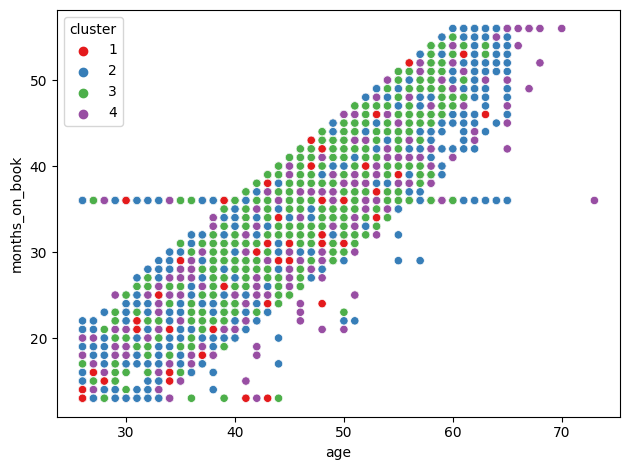

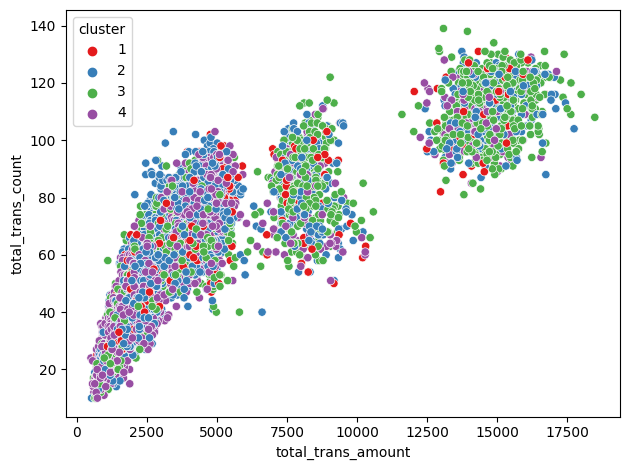

In [15]:
sns.scatterplot(data=dataset, x='age', y='months_on_book', hue='cluster', palette='Set1')
plt.tight_layout()
plt.show()

sns.scatterplot(data=dataset, x='total_trans_amount', y='total_trans_count', hue='cluster', palette='Set1')
plt.tight_layout()
plt.show()

From above, there is no clear result on `age` vs `months_on_book`. But the second graph, we can see that the `cluster_3` is higher for both `total_trans_amount` & `total_trans_count`, while `cluster_2` and `cluster_4` are distributed at the left bottom.

### Categorical Variables by `CLUSTER`

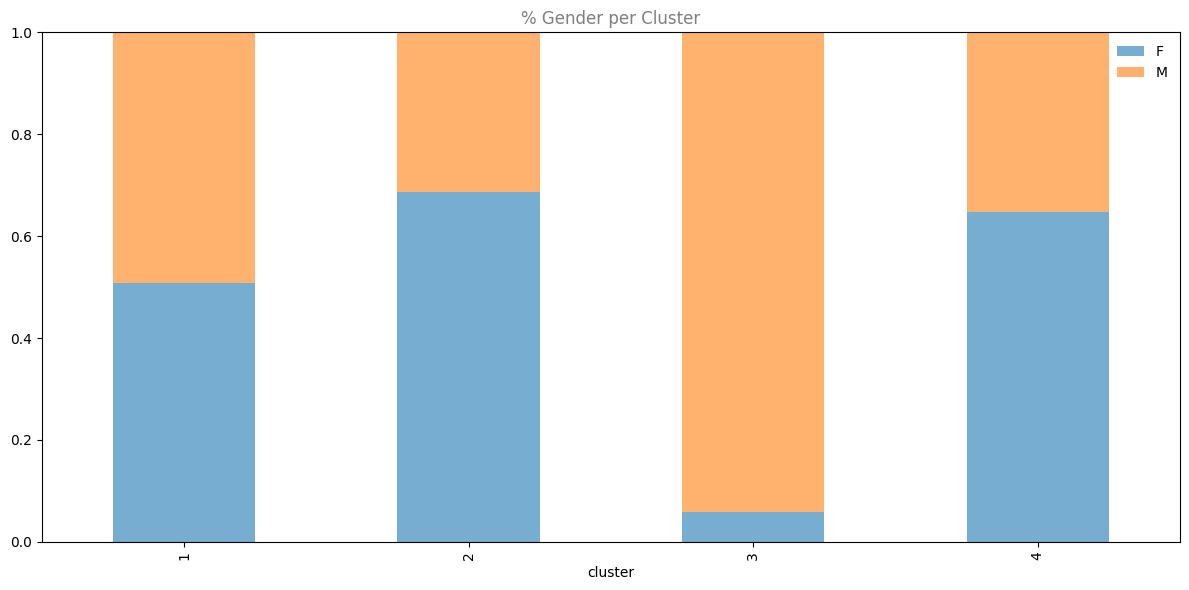

In [16]:
plot_df = pd.crosstab(
  index=dataset['cluster'], columns=dataset['gender'],
  values=dataset['gender'], aggfunc='size', normalize='index')

fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
ax.set_title(f'% Gender per Cluster', alpha=0.5)

ax.set_ylim(0, 1)
ax.legend(frameon=False)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

We can see that:
- `cluster_1` is 50/50 **Males** to **Females**
- Almost all of the customer in `cluster_3` are **Male**
- Both `cluster_2` and `cluster_4` have about 70% of **Female**

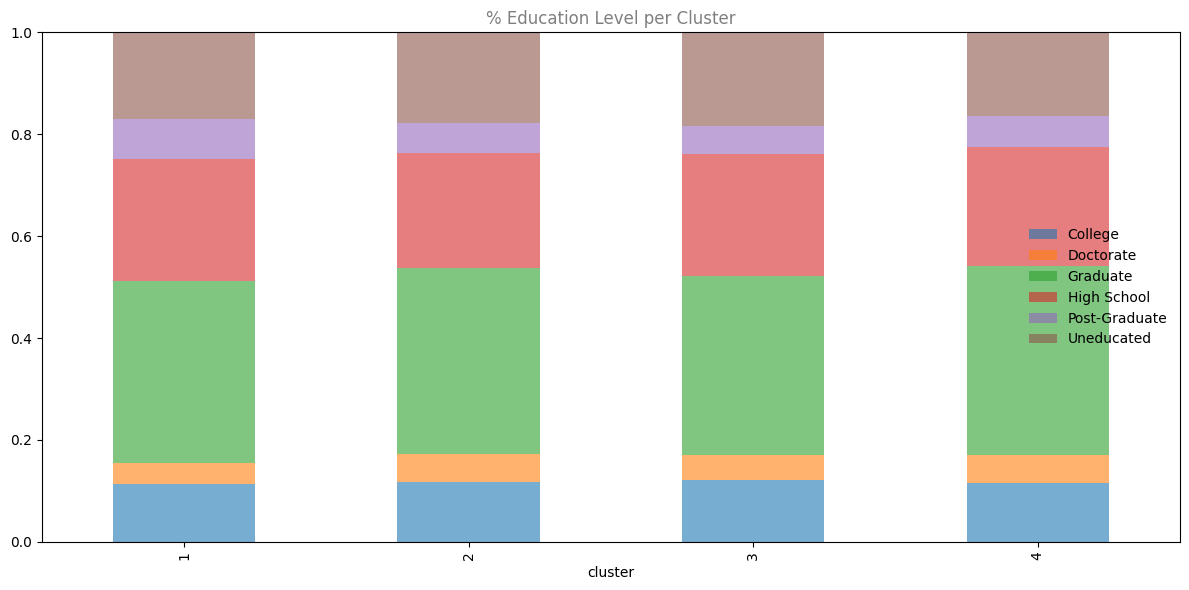

In [17]:
plot_df = pd.crosstab(
  index=dataset['cluster'], columns=dataset['education_level'],
  values=dataset['education_level'], aggfunc='size', normalize='index')

fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
ax.set_title(f'% Education Level per Cluster', alpha=0.5)

ax.set_ylim(0, 1)
ax.legend(frameon=False)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

Education levels are fairly uniform across all clusters...

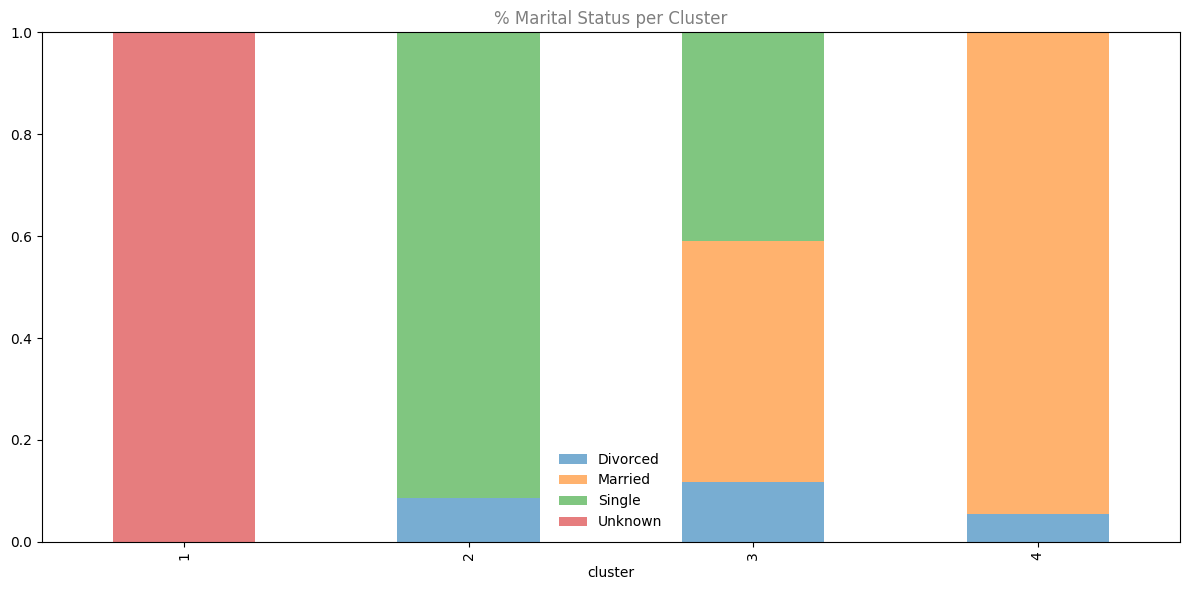

In [18]:
plot_df = pd.crosstab(
  index=dataset['cluster'], columns=dataset['marital_status'],
  values=dataset['marital_status'], aggfunc='size', normalize='index')

fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
ax.set_title(f'% Marital Status per Cluster', alpha=0.5)

ax.set_ylim(0, 1)
ax.legend(frameon=False)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

For the marital status:
- `cluster_1` is all **Unknown**.
- Almost all of the customer in `cluster_2` are **Single**.
- In `cluster_3`, they're mostly mix of **Single** and **married**.
- Almost all of the customer in `cluster_4` are **Married**.

## Overall for each `CLUSTER` with recommendations

`Cluster 1`:
- Equality on gender, and unknown marital status
- Middle estimated income, credit limit, total transaction amount, credit card utilization ratio.
- No prominence on the rest of the variables.

Thus, it's very difficult to make any recommendations with the 'average' result.

`Cluster 2` & `Cluster 4`:
- Both have the similar result except marital status, mostly single or married.
- Both have around 70% of Female.
- Both have overall low stimated income and credit limit, but high redit card utilization ratio.
- No prominence on the rest of the variables.

They're likely to be in the begining of their career or supporting a large family. Offering **cashback or discounts** on essential categories like groceries and utilities may align with their needs and help retain their loyalty. Additionally, providing **flexible payment options**, such as installment plans for large purchases, can sustain their purchasing power. Besides, we can also provide **lower interest rates** for customers with high utilization ratios, to reduce the risk of bad-debt.

`Cluster 3`:
- Equality mix of single and married, with about 10% of divorced.
- Has overall high stimated income and credit limit, but low redit card utilization ratio.
- No prominence on the rest of the variables.

The customers in this cluster tend to be in the peak of their career. The low utilization suggests they're able to manage their debt responsibly. Thus, we may promoting them with premium credit cards offering higher credit limits, travel benefits, or exclusive rewards. Offering promotions in luxury categories such as travel, dining, or lifestyle products may further encourage higher spending. Besides, we can introduce them with investment-linked credit products that can help them grow wealth, creating a win-win situation.

## Moving Forward

- Since there are 2 clusters have the similar result, we may consider to reduce the numbers of clusters to 3. Also, we can try to increase to see if there is any difference.
- Use fewer variables in the clusterization and explain what changes this brings to the model.